# 2019 04 28 OpenCV tests
## k-means

In [1]:
import os
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt # plt.imshow()
import cv2
from skimage import data, filters
from skimage.morphology import disk
from skimage.external import tifffile as tf


def main():
    os.chdir("/home/c/Documents/Academic/BI3002 Biosciences Erasmus "
             "Placement Research Project/CellCounter")
    tifobj = tf.TiffFile("testack.lsm")
    arr = tifobj.asarray()
    return arr


class LSM:

    def __init__(self):
        self.red_sum = {}
        self.green_sum = {}
        self.blue_sum = {}
        self.red_max = {}
        self.green_max = {}
        self.blue_max = {}

    def project_channel_sum(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_sum = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_sum = np.add(channel_sum, arr[0, 0, i, channelid, :, :])
        # Normalize, first 0 - 1, then to max = 255 (uint8)
        channel_sum = channel_sum.astype(np.float64) / channel_sum.max()
        channel_sum = 255 * channel_sum
        channel_sum = channel_sum.astype(np.uint8)
        return channel_sum

    def project_channel_max(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_max = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_max = np.fmax(channel_max, arr[0, 0, i, channelid, :, :],
                                  dtype=np.int8)
        # Normalize, first 0 - 1, then to max = 255
        channel_max = channel_max.astype(np.float64) / channel_max.max()
        channel_max = 255 * channel_max
        channel_max = channel_max.astype(np.uint8)
        return channel_max

    red_sum = project_channel_sum(0)
    green_sum = project_channel_sum(1)
    blue_sum = project_channel_sum(2)

    red_max = project_channel_max(0)
    green_max = project_channel_max(1)
    blue_max = project_channel_max(2)


lsm1 = LSM

rgb = np.dstack([lsm1.red_max,    # R
                 lsm1.green_max,  # G
                 lsm1.blue_max])  # B

rgb = np.moveaxis(rgb, -1, 0)

tf.imsave('rgb.tiff', rgb)


class Filter(LSM):
    '''
    Carlos, ten en cuenta que el efecto de los filtros depende de la forma y tamaño de los 'kernels' o
    'structuring elements'. Por defecto se usan un 'disco' de 1pxl de diametro, creo.
    Es posible que algo de experimentación con el tamaño de un disco fuera conveniente.

    Puedes probar
    from skimage.morphology import disk
    diameter = something between 5 and 20 to start with?
    strel = disk(diameter)
    '''
    
    def __init__(self):
        pass

    def median_filter(volume): # to be replaced with new filter
        filtered = scipy.signal.medfilt(volume)
#        filtered = filters.median(volume, strel)
        return filtered

    def otsu_thesholding(image):
        thresholded = image > filters.threshold_otsu(image)
        return thresholded


arr = main()


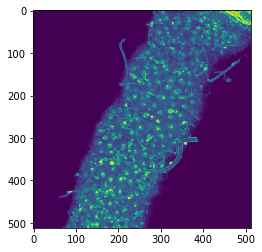

In [2]:
dapi = rgb[2,:,:] # define DAPI channel to make the mask

mask = filters.apply_hysteresis_threshold(dapi, np.min(dapi)*2, np.max(dapi)*0.9) # create said gut mask

# quick filter + mask
def treat_channels():
    for i in range(0, 3):
        rgb[i,:,:] = filters.median(rgb[i,:,:], disk(1)) # median filter each channel
        rgb[i,:,:] = rgb[i,:,:] * mask # apply the mask made according to dapi
        plt.imshow(rgb[i,:,:]) # debug

treat_channels()

In [3]:
prospero = rgb[0,:,:]
delta = rgb[1,:,:]
dapi = rgb[2,:,:]

#img = dapi

Z = dapi.flatten()
Z = np.float32(Z) # np.float32 required

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0) # criteria required in a 3 item tuple
K = 3 # number of clusters, referred to the number of colors
attempts=10 # max attempts until stop. Default = 10
ret,label,center=cv2.kmeans(Z,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

# Now convert back into uint8
#now we have to access the labels to regenerate the clustered image
center = np.uint8(center)
result0 = center[label.flatten()]
result1 = result0.reshape((dapi.shape))

## Plots a greyscale of 'before' and 'after' k means clustering
#cv2.imshow("result0",result0)
#cv2.waitKey()
#cv2.destroyAllWindows()

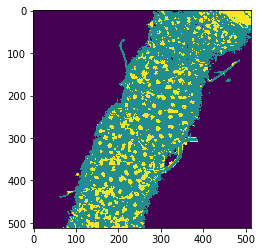

In [4]:
plt.imshow(result1) # clustering result

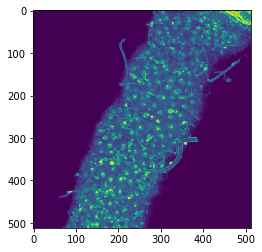

In [5]:
plt.imshow(dapi) # DAPI channel to compare with the clustering

## Watershed
Based on the opencv tutorial

In [7]:
ret, thresh = cv2.threshold(img,0,512,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

NameError: name 'img' is not defined

Why an error?? (+ confusing error message)